# 1D Metaplectic Geometrical Optics - Tracing Rays and Calculating Amplitude

## 1D MGO Solution to Airy Problem

### Setup

In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func

from scipy.integrate import cumulative_trapezoid
from scipy.special import airy
from scipy.signal import find_peaks
from skimage.segmentation import flood

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [3]:
def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

def sgn_mask_from_seed(a, seed):
    '''returns boolean array mask for the "sign branch" connected to the seed index.
    A "sign branch" is here defined as a connected region where the sign of the array `a` is constant.
    '''
    return flood(np.signbit(a), seed)

def get_masks_of_const_sgn(a, ND=3):
    '''returns list of boolean arrays with masks which
    subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    seed = (0) * ND
    regions_remaining = True
    masks = []
    while regions_remaining:
        masks.append(sgn_mask_from_seed(a, seed))
        remaining_cells = np.argwhere(np.any(masks, axis=0) == False)
        if len(remaining_cells) > 0:
            seed = tuple(remaining_cells[0])
        else:
            regions_remaining = False
    return masks

### Dispersion function and ICs

In [4]:
@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return - x - k**2

In [5]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

x = np.linspace(-12, 0, 1000)
E_ex = Ai(x) # Exact solution is Airy function

# Set ICs from Airy function
first_peak_ind = find_peaks(E_ex)[0][0]
x0  = x[first_peak_ind]
phi0 = E_ex[first_peak_ind]

In [6]:
x0, phi0

(-11.471471471471471, 0.3064946918850257)

### Ray Tracing

In [7]:
nt = 1000
xs = np.zeros(nt)
ks = np.zeros(nt)
omega0 = 1.0

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

sol = trace_ray_1D(x0 = x0, k0=np.sqrt(-x0), omega0=omega0, tmin=0, tmax=8, D=D, x_min=x0, tsteps=nt)
sol_nt = len(sol.t)
xs[:sol_nt] = sol.y[0]
ks[:sol_nt] = sol.y[1]
min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
xs = xs[:min_nt]
ks = ks[:min_nt]

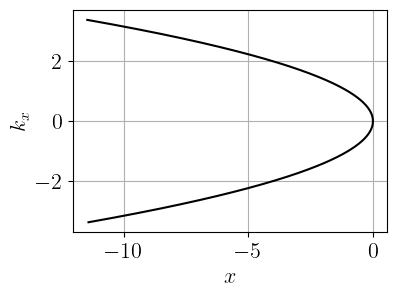

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(xs, ks, 'k-')
plt.tight_layout()
plt.savefig('./plots/1D_MGO_airy_dispersion_manifold.png')
plt.savefig('./plots/1D_MGO_airy_dispersion_manifold.pdf')
# plt.xlim(-8, 0)
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
plt.grid()
plt.show()

### Canonical/Symplectic Trfm

In [9]:
def gram_schmidt_orthogonalize(Q):
    N = Q.shape[-1]
    P = np.zeros(Q.shape)

    def norm(A, i):
        norms = np.sqrt(np_inner_product(A[..., i], A[..., i]))
        return np.stack([norms]*A.shape[-1], axis=-1)

    P[..., 0] = Q[..., 0]/norm(Q, 0)
    for k in range(1, N):
        P[..., k] = (Q[..., k]
                        - sum([(
            np.stack([np_inner_product(Q[..., k], P[..., j])]*N, axis=-1)
            ) * P[..., j] for j in range(k)]))
        P[..., k] = P[..., k]/norm(P, k)
    return P

In [10]:
ND = 1
zs = np.stack((xs, ks), axis=-1)
gradt_z = fd.grad(zs, t)
norms = np.sqrt(np_inner_product(gradt_z, gradt_z))
T1 = gradt_z/np.stack([norms]*zs.shape[-1], axis=-1) # normalised grad_t z(t, y0, z0)

# For each tau, create an identity matrix
eye = np.zeros(np.prod(zs.shape)*zs.shape[-1]).reshape((*zs.shape, zs.shape[-1]))
eye[..., :, :] = np.eye(zs.shape[-1])

# For each tau, create orthonormal basis starting from
# single tangent vector using Gram Schmidt orthogonalization
ONB = np.copy(eye)
ONB[..., 0] = T1
ONB = gram_schmidt_orthogonalize(ONB)

# Tangent space is first 3 vectors of basis:
# Note: Basis vectors in T are shaped as columns!
T = ONB[..., :ND]

# Create Symplectic Matrix (J)
symplJ = np.copy(ONB)
symplJ[..., :, :] =  np.block([
    [  np.zeros((ND, ND)),  np.eye((ND))        ],
    [  -np.eye(ND),         np.zeros((ND, ND))  ]])

def np_transpose(A):
    '''return transpose of only the last two dimensions.'''
    return np.moveaxis(A, -1, -2)

# Create symplectic/canonical transformation matrix
N = -np.matmul(symplJ, T)
R = np.concatenate((T, N), axis=-1)
S = np_transpose(R)
gradt_S = fd.grad(S, t)

In [11]:
# print(
#     'sample tests of matrices',
#     '\n\n T^T T \n',
#     np.matmul(np_transpose(T), T)[0:3, 0, 0],
#     '\n\n N^T N \n',
#     np.matmul(np_transpose(N), N)[0:3, 0, 0],
#     '\n\n N^T J T \n',
#     np.matmul(np_transpose(N), np.matmul(symplJ, T))[0:3, 0, 0],
#     '\n\n T^T J T \n',
#     np.round(np.matmul(np_transpose(T), np.matmul(symplJ, T))[0:3, 0, 0], 4),
# )

#### Digression: Inspection of Tangent and Normal Vectors

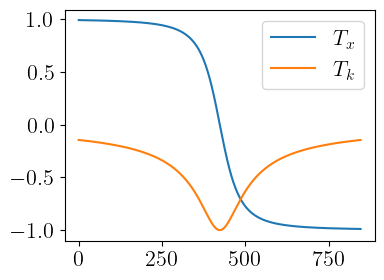

In [12]:
plt.figure(figsize=(4,3))
plt.plot(T.squeeze())
plt.legend([r'$T_{x}$', r'$T_{k}$'])
plt.show()

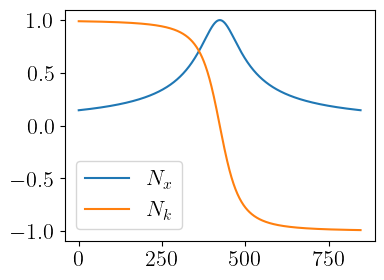

In [13]:
plt.figure(figsize=(4,3))
plt.plot(N.squeeze())
plt.legend([r'$N_{x}$', r'$N_{k}$'])
plt.show()

Comparison with Lopez Expressions:

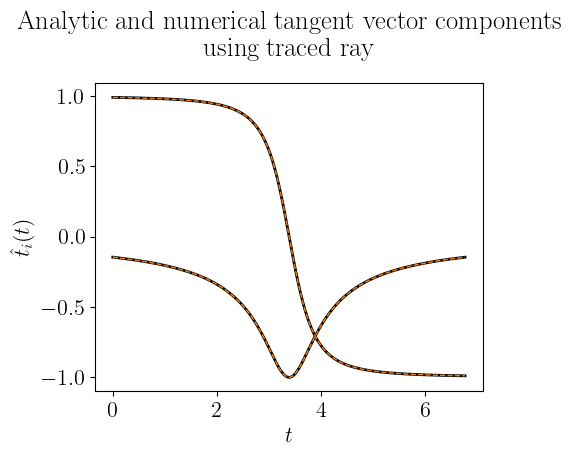

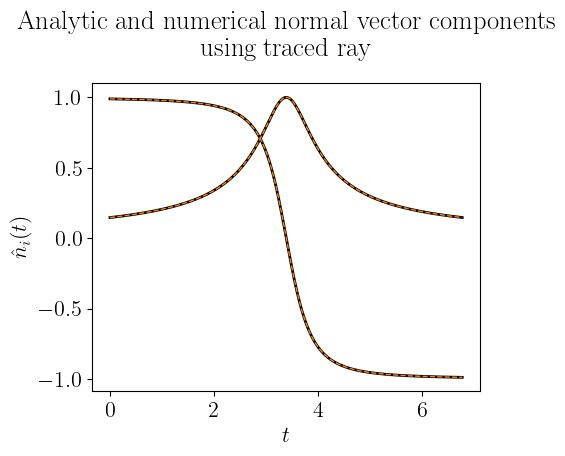

In [14]:
v_ex = np.sqrt(1+4*(ks**2))
T_ex = np.stack([ 1/v_ex * 2*ks, -1/v_ex * np.ones_like(ks)], axis=-1) # tangent matrix from Lopez example
N_ex = np.stack([ 1/v_ex * np.ones_like(ks), 1/v_ex * 2*ks ], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T.squeeze(), '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_ex, '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using traced ray')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N.squeeze(), '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_ex.squeeze(), '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using traced ray')
plt.show()

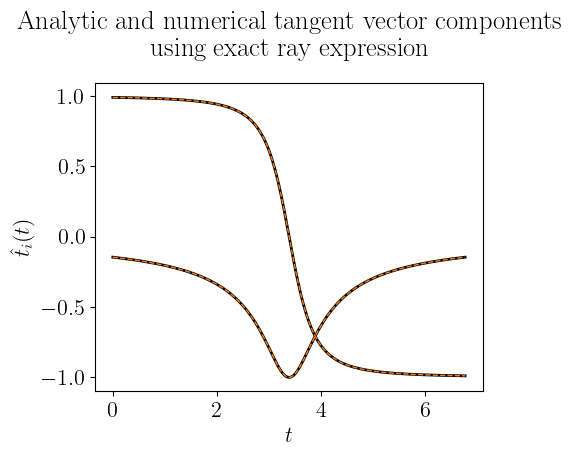

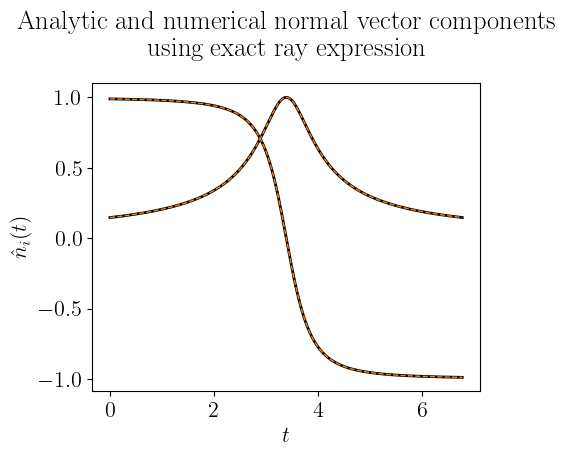

In [15]:
ks_ex = ks[0] - t
v_exx = np.sqrt(1+4*(ks_ex**2))
T_exx = np.stack([ 1/v_ex * 2*ks_ex, -1/v_ex], axis=-1) # tangent matrix from Lopez example
N_exx = np.stack([ 1/v_ex, 1/v_ex * 2*ks_ex], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T.squeeze(), '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_exx, '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using exact ray expression')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N.squeeze(), '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_exx, '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using exact ray expression')
plt.show()

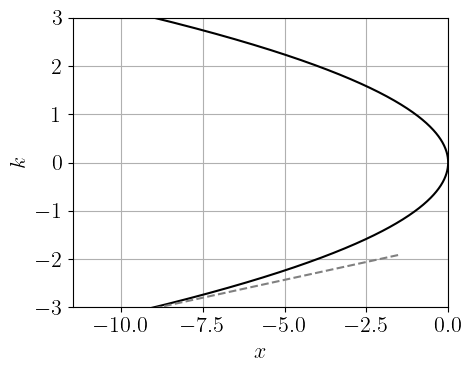

In [16]:
from matplotlib import animation

fig = plt.figure(figsize=(5,4))
plt.plot(xs, ks, 'k-')
plt.xlim(np.min(xs), 0)
plt.ylim(-3, 3)
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$k$')

t_param = np.linspace(-10, 10, 2)

tangent = plt.plot(xs[0] + T[0, 0] * t_param, ks[0] + T[0, 1] * t_param, '--', color='grey')[0]
normal = plt.plot(xs[0] + N[0, 0] * t_param, ks[0] + N[0, 1] * t_param, '--', color='grey')[0]

def update(frame):
    tangent.set_xdata(xs[frame] + T[frame, 0] * t_param)
    tangent.set_ydata(ks[frame] + T[frame, 1] * t_param)

    normal.set_xdata(xs[frame] + N[frame, 0] * t_param)
    normal.set_ydata(ks[frame] + N[frame, 1] * t_param)
    return tangent, normal

plt.tight_layout()
anim = animation.FuncAnimation(fig=fig, func=update, frames=xs.shape[0], blit=True)
anim.save('./plots/1D_MGO_tangent_animation_nt_' + str(nt) + '.gif', fps=int(xs.shape[0]/20))

In [16]:
print('all normal vectors are orthogonal to tangent vectors?', np.all(np.isclose(np_inner_product(N.squeeze(), T.squeeze()), 0)))

all normal vectors are orthogonal to tangent vectors? True


### MGO

In [17]:
from gauss_freud_quad import integrate_gauss_freud_quad, get_nodes_and_weights
from scipy.optimize import brentq

In [18]:
def neighbourhood(i, N, N_neighbours=1):
    '''returns slice corresponding to neighbourhood of i
        and index of i in sliced array.'''
    if i < 0 or i >= N:
        raise ValueError('index for neighbourhood is out of bounds')
    if i - N_neighbours < 0:
        return slice(min(1+2*N_neighbours, N)), i
    if i + N_neighbours >= N:
        return slice(max(0, N-(1+2*N_neighbours)), N), - (N-i)
    return slice(i - N_neighbours, i + N_neighbours + 1), N_neighbours

In [51]:
from numpy.polynomial.polynomial import Polynomial

def G1(x, X, S):
    A, B, C, D = S[..., 0, 0], S[..., 0, 1], S[..., 1, 0], S[..., 1, 1]
    return ( 
        1/2 * x * (1/B) * A * x
        - x * (1/B) * X
        + 1/2 * X * D * (1/B) * X
    )

def GO_on_tangent_plane(i1, S_t0, Zs_t0):
    '''Returns Xs_t0, Ks_t0, mask_t0, Phi_t0, f_taylor, g_taylor, ddf_taylor'''
    # GO on tangent plane. Calculate Field in rotated phase space.
    Xs_t0 = Zs_t0[..., :ND].squeeze()
    Ks_t0 = Zs_t0[..., ND:].squeeze()
    gradt_Xs_t0 = fd.grad(Xs_t0, t)
    Theta0 = 0
    int_0_to_tau = cumulative_trapezoid(Ks_t0 * gradt_Xs_t0, t, initial=0, axis=0)
    Theta_t0 = Theta0 + int_0_to_tau - int_0_to_tau[i1]
    J_t0 = fd.grad(Xs_t0, t)
    Phi_t0 = np.emath.sqrt(J_t0[i1]/J_t0) # Amplitude set to 1 at tau = t (time index i1)
    mask_t0 = sgn_mask_from_seed(J_t0, (i1)) # get current branch
    Field_t0 = Phi_t0*np.exp(1j*Theta_t0) * mask_t0 # only include contribution from current branch

    B_t0, D_t0 = S_t0[0, 1], S_t0[1, 1]
    eps_t0 = Xs_t0 - Xs_t0[i1]
    
    gamma_t0 = ((1/2) * (eps_t0 * D_t0 * (1/B_t0) * eps_t0)
                + (D_t0 * Xs_t0[i1] - xs[i1]) * (1/B_t0) * eps_t0)
    f_t0 = Theta_t0 - gamma_t0
    
    domain = [0.1*np.min(eps_t0[mask_t0]), 0.1*np.max(eps_t0[mask_t0])]
    f_fit = Polynomial.fit(eps_t0[mask_t0], f_t0[mask_t0], deg=6, domain=domain)
    ddf_fit = f_fit.deriv(2)
    g_fit_Re = Polynomial.fit(eps_t0[mask_t0], np.real(Phi_t0[mask_t0]**(-4)), deg=1, domain=domain)
    g_fit_Im = Polynomial.fit(eps_t0[mask_t0], np.imag(Phi_t0[mask_t0]**(-4)), deg=1, domain=domain)
    g_fit = lambda eps: np.emath.power(g_fit_Re(eps) + 1j*g_fit_Im(eps), -1/4)

    return Xs_t0, Ks_t0, mask_t0, Phi_t0, Field_t0, Theta_t0, gamma_t0, f_fit, g_fit, ddf_fit, eps_t0, f_t0

In [52]:
def integral(f, g, sigma_p, sigma_m, s_p, s_m, eps_0=0):
    h = lambda eps: g(eps) * np.exp(1j*f(eps))
    dl_p, dl_m = np.exp(1j*sigma_p)/np.sqrt(s_p), np.exp(1j*sigma_m)/np.sqrt(s_m)
    I = integrate_gauss_freud_quad(
        lambda l: (h(eps_0 + l*dl_p) * dl_p - h(eps_0 + l*dl_m) * dl_m),
        n = 2
    )
    return I

def start_angles(ddf, eps_0=0):
    alpha = np.angle(ddf(eps_0))
    sigma_p = -np.pi/4 - alpha/2 + np.pi/2
    sigma_m = -np.pi/4 - alpha/2 - np.pi/2
    return sigma_p, sigma_m

def get_l_and_s(f, sigma_p, sigma_m, eps_0=0):
    Delta_F = 1

    C_p = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_p)
    C_m = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_m)

    F_p = lambda l: np.imag(f(C_p(l)))
    F_m = lambda l: np.imag(f(C_m(l)))

    l_p = brentq(lambda l: F_p(l) - F_p(0) - Delta_F, 0, 10)
    l_m = brentq(lambda l: F_m(l) - F_m(0) - Delta_F, 0, 10)
    
    s_p = Delta_F/(np.abs(l_p)**2)
    s_m = Delta_F/(np.abs(l_m)**2)

    return l_p, l_m, s_p, s_m

def new_angle(f, sigma, r, Delta_sigma = 0.1):
    '''Calculate new direction of steepest descent
        in Delta_sigma neighbourhood of old direction, sigma.'''
    C_circ = lambda _r, theta: _r*np.exp(1j*theta)
    F_circ = lambda theta: np.imag(f(C_circ(r, theta)))
    sigmas = np.linspace(sigma - Delta_sigma/2, sigma + Delta_sigma/2)
    new_angle = sigmas[np.argmax(F_circ(sigmas))]
    return new_angle

In [71]:
# Times at which to save results
time_in_s = lambda s: np.argmin(np.abs(ks)) + int(s * nt/max(t))
t_insp_in_s = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
t_insp = [time_in_s(s) for s in t_insp_in_s]
results = []

# Initialization for t = 0
nbh_slice0, nbh_i0 = neighbourhood(0, nt)
S_nbh = S[nbh_slice0]
Zs_nbh = np.zeros((S_nbh.shape[0], *zs.shape))
for nbh_i, S_t0 in enumerate(S_nbh):
    Zs_nbh[nbh_i, ...] = np.matmul(S_t0, zs[..., np.newaxis]).squeeze()

S_t0 = S_nbh[nbh_i0]
Zs_t0 = Zs_nbh[nbh_i0]

Xs_t0, Ks_t0, mask_t0, Phi_t0, Field_t0, Theta_t0, gamma_t0, f_fit, g_fit, ddf_fit, eps_t0, f_t0 = GO_on_tangent_plane(0, S_t0, Zs_t0)

sigma_p, sigma_m = start_angles(ddf_fit)
l_p, l_m, s_p, s_m = get_l_and_s(f_fit, sigma_p, sigma_m)


Upsilon = np.zeros_like(t, dtype=np.complex_)
eta_t = np.zeros_like(t, dtype=np.complex128)

for i1, t0 in enumerate(t):
    print(str(i1+1) + '/' + str(len(t)), end='\r')
    # Set quantities for neighbouring times. The position for neighbouring times
    # is needed to calculate the total derivative in time which accounts for both
    # the change in position with time and the change in the symplectic transform.
    nbh_slice, nbh_i = neighbourhood(i1, nt)
    t_nbh = t[nbh_slice]
    S_nbh = S[nbh_slice]
    Zs_nbh[-1, ...] = np.matmul(S_nbh[-1], zs[..., np.newaxis]).squeeze()      
    Xs_t = Zs_nbh[..., :ND].squeeze()
    
    S_t0 = S_nbh[nbh_i]
    Zs_t0 = Zs_nbh[nbh_i]

    Xs_t0, Ks_t0, mask_t0, Phi_t0, Field_t0, Theta_t0, gamma_t0, f_fit, g_fit, ddf_fit, eps_t0, f_t0 = GO_on_tangent_plane(i1, S_nbh[nbh_i], Zs_nbh[nbh_i])
    
    sigma_p, sigma_m = new_angle(f_fit, sigma_p, l_p), new_angle(f_fit, sigma_m, l_m)

    if np.isclose(ks[i1], 0, atol=1e-4):
        Upsilon[i1] = Upsilon[i1-1]
    else:
        Upsilon[i1] = integral(f_fit, g_fit, sigma_p, sigma_m, s_p, s_m)

    # Calculate eta_t needed for amplitude factor, alpha_t
    dS = gradt_S[i1] @ np.linalg.inv(S_t0)
    W_t0, U_t0, V_t0 = dS[:ND,ND:].squeeze(), -dS[ND:,:ND].squeeze(), -dS[ND:, ND:].squeeze()
    # # Uncomment to print errors of U, W compared to the analytical expression
    # print('error on U, W: ',
    #       np.round(np.abs(- 2/(v_ex[i1]**2) -  W_t0), 4),
    #       np.round(np.abs(- 2/(v_ex[i1]**2) -  U_t0), 4))
    gradh_X = np.sum(
        fd.grad(Xs_t[:, nbh_slice], t_nbh, t_nbh)[nbh_i, nbh_i, ...],
        axis=-1)
    gradX_phi = fd.grad(Phi_t0[nbh_slice], Xs_t0[nbh_slice])[nbh_i]
    eta_t[i1] = (
        (gradh_X - V_t0 * Xs_t0[i1] - W_t0 * Ks_t0[i1]) *
        (gradX_phi + 1j * Ks_t0[i1])
        - (1/2) * V_t0
        - 1j * ( Xs_t0[i1] * U_t0 * Xs_t0[i1] )
        + (1j/2) * ( Ks_t0[i1] * W_t0 * Ks_t0[i1] )
    )

    if i1 in t_insp:
        results.append({'mask_t0': mask_t0, 'eps_t0': eps_t0, 'f_t0': f_t0, 'Field_t0': Field_t0, 'Theta_t0': Theta_t0, 'gamma_t0': gamma_t0, 'f_fit': f_fit, 'ddf_fit': ddf_fit, 'g_fit': g_fit, 'sigma_p': sigma_p, 'sigma_m': sigma_m})
    
    # Prepare for next calculation
    Zs_nbh = np.roll(Zs_nbh, shift=-1, axis=0)

In [72]:
alpha_0 = 1 # (0.2595-0.3372j)
alpha_t = alpha_0 * np.exp(cumulative_trapezoid(eta_t, t, initial=0))

Zs_t_t = (S @ zs[..., np.newaxis]).squeeze()
Xs_t_t = Zs_t_t[..., 0]
beta_t = G1(xs, Xs_t_t, S)
# beta_t0 = G1(xs[i1], Xs_t0[i1], S_t0)
# alpha_t0 = alpha_t[i1]
B_t, D_t = S[..., 0, 1], S[..., 1, 1]
# prefact_t0 = ( alpha_t0 * np.exp(-1j * beta_t0)
#         / ( ((-2*np.pi*1j)**(ND/2)) * np.emath.sqrt(B_t0) ) )

prefact_t = ( alpha_t * np.exp(-1j * beta_t)
        / ( ((-2*np.pi*1j)**(ND/2)) * np.emath.sqrt(B_t) ) )

### Inspect Results

(-3.0, 3.0)

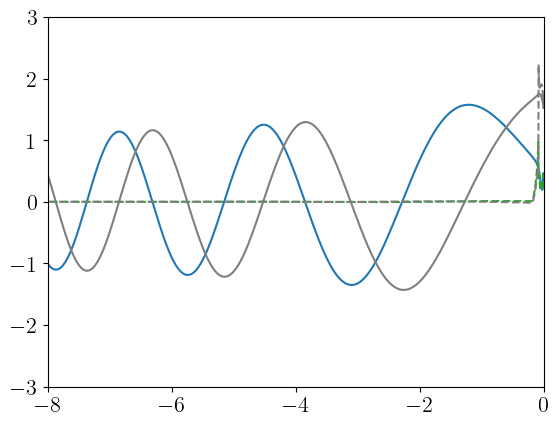

In [73]:
plt.plot(xs[:int(nt/2)], np.real(prefact_t[:int(nt/2)]*Upsilon[:int(nt/2)]))
plt.plot(xs[:int(nt/2)], np.imag(prefact_t[:int(nt/2)]*Upsilon[:int(nt/2)]), color='tab:grey')
plt.plot(xs[int(nt/2):], np.real(prefact_t[int(nt/2):]*Upsilon[int(nt/2):]), '--', color='tab:green')
plt.plot(xs[int(nt/2):], np.imag(prefact_t[int(nt/2):]*Upsilon[int(nt/2):]), '--', color='tab:grey')
plt.xlim(-8,0)
plt.ylim(-3,3)

### Complex Phase Plots

In [74]:
# Define analytical functions for comparison with numerical results
v_anal = lambda p: np.sqrt(1+4*(p**2))
f_anal = lambda eps, p: (
    (v_anal(p)**6 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(3/2))/(96*(p**3))
    - v_anal(p)**3/(8*(p**2)) * eps + v_anal(p)**2/(4*p) * eps**2
    )
df_anal = lambda eps, p: v_anal(p)/(8*(p**2)) * (
    4*v_anal(p)*p*eps
    - v_anal(p)**2
    + (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/2)
    )
ddf_anal = lambda eps, p: v_anal(p)**2/(2*p) * (1 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(-1/2)) 
g_anal = lambda eps, p: (1/(2*np.pi)) * v_anal(p)/(v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/4)

In [75]:
C = lambda l, sigma_p, sigma_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m), lambda l: np.exp(1j*sigma_p)])
C_R = lambda l, sigma_p, sigma_m: np.real(C(l, sigma_p, sigma_m))
C_I = lambda l, sigma_p, sigma_m: np.imag(C(l, sigma_p, sigma_m))

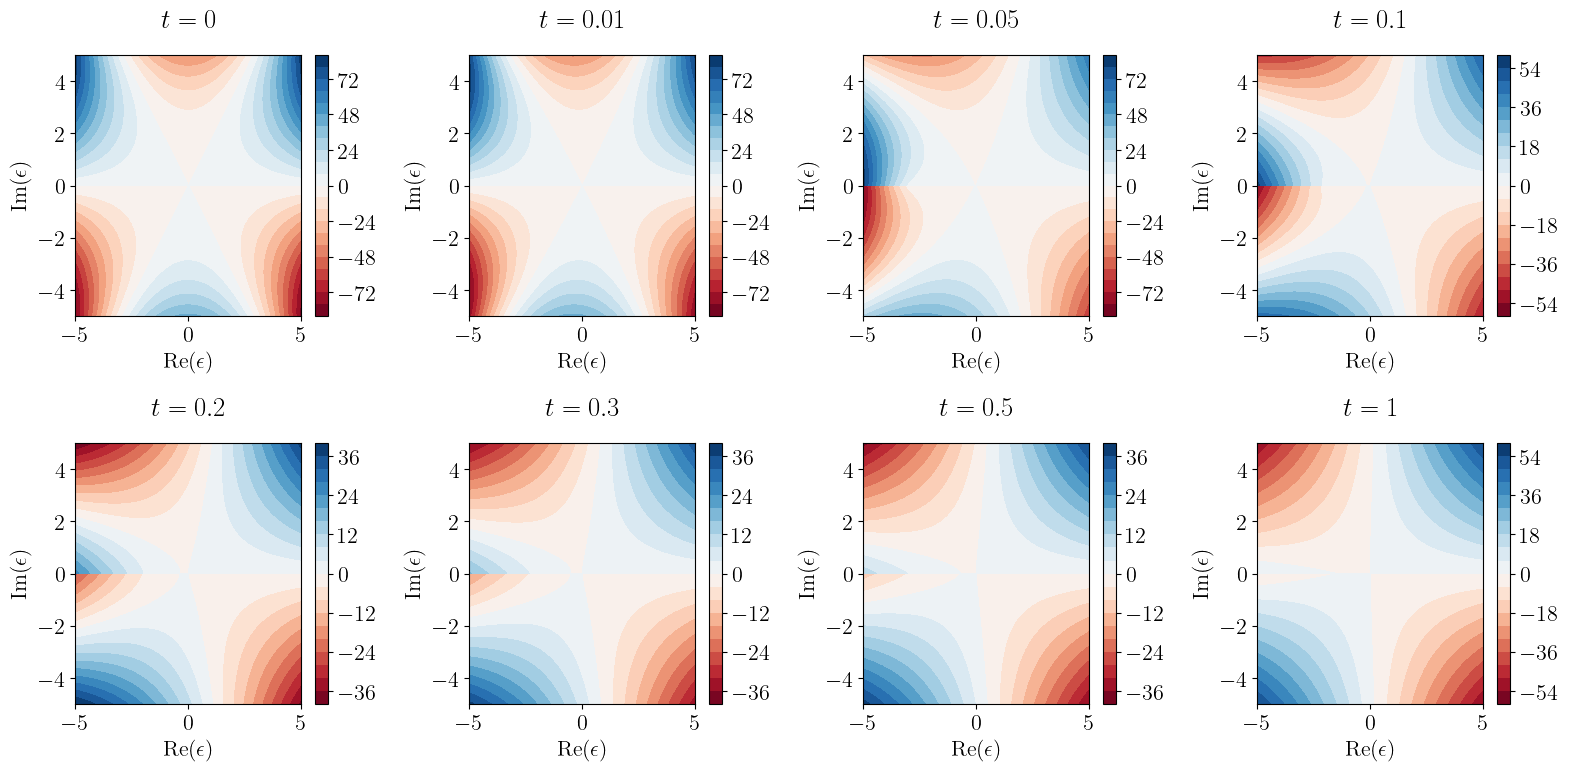

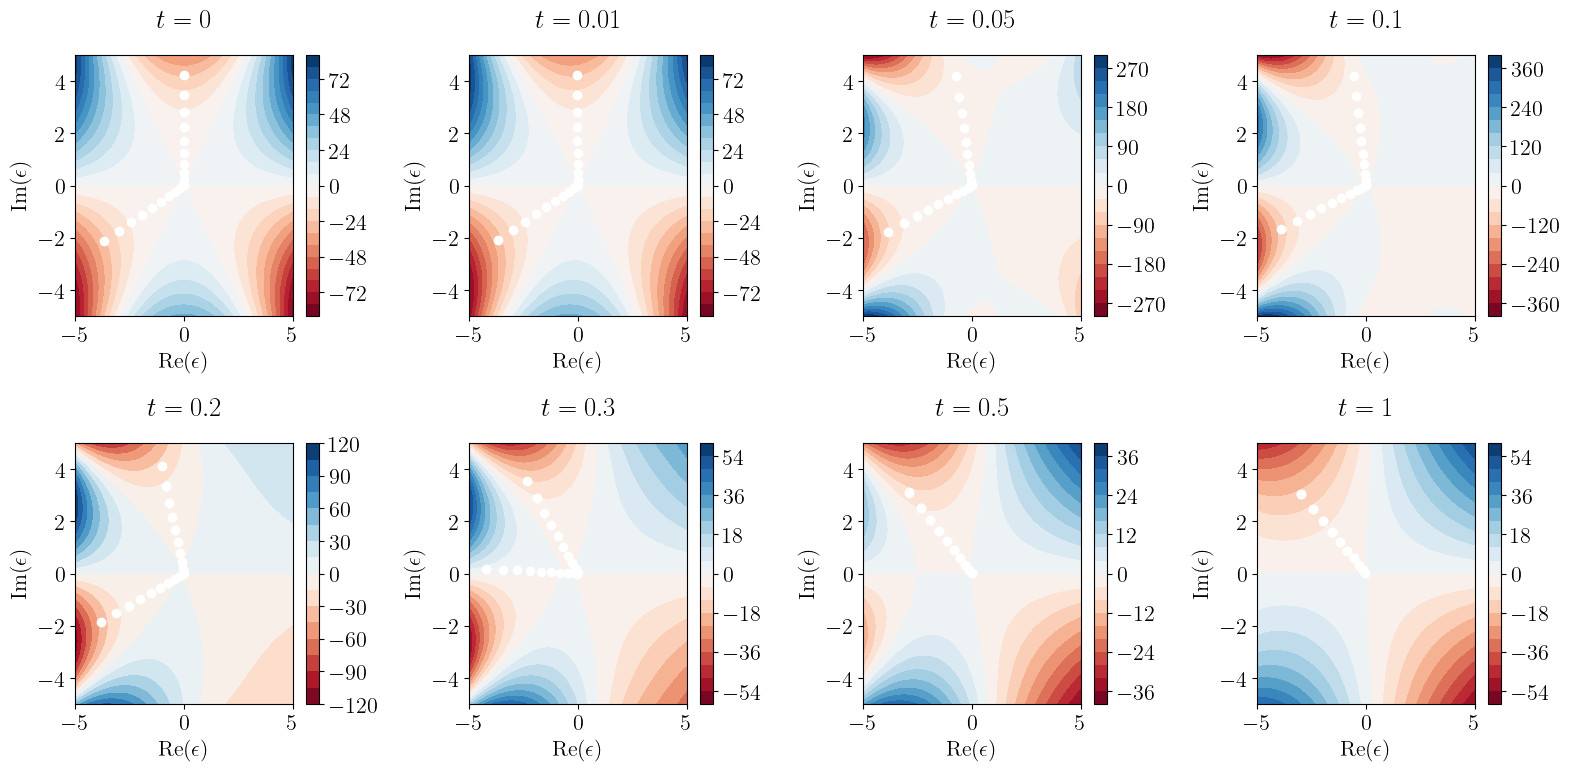

In [76]:
eps_R = np.linspace(-5,5, 1000)
eps_I = np.linspace(-5,5, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I

k_vals = [ks[i] for i in t_insp]
# # p_vals = [0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 1.5, 2.0]
nrows, ncols = int(np.ceil(len(k_vals)/4)), 4
# fig, axes = plt.subplots(nrows, ncols, figsize=(14,8))
fig = plt.figure(figsize=(ncols*4,nrows*4))

for i, k in enumerate(k_vals):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_anal(Eps, k)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$t = ' + str(np.round(t_insp_in_s[i],2)) + '$')
    ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(ncols*4,nrows*4))

for i, k in enumerate(k_vals):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    results_i = results[i]
    mask_t0, eps_t0, f_t0, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = results[i]['mask_t0'], results[i]['eps_t0'], results[i]['f_t0'], results[i]['f_fit'], results[i]['ddf_fit'], results[i]['g_fit'], results[i]['sigma_p'], results[i]['sigma_m']
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps)), cmap='RdBu', levels=20)
    # contour_plot = ax.contourf(Eps_R, Eps_I, np.real(ddf_fit(Eps)), cmap='RdBu', levels=20)
    # contour_plot = ax.contourf(Eps_R, Eps_I, np.imag(ddf_fit(Eps)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$t = ' + str(np.round(t_insp_in_s[i],2)) + '$')
    ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    l_j, _ = get_nodes_and_weights(n=10)
    l_j = l_j.astype(np.complex_)
    ax.plot(C_R(-l_j, sigma_p, sigma_m), C_I(-l_j, sigma_p, sigma_m), 'ow')
    ax.plot(C_R(l_j, sigma_p, sigma_m), C_I(l_j, sigma_p, sigma_m), 'ow')
plt.tight_layout()
plt.show()

In [118]:
i_insp = 7
it = t_insp[i_insp]
print('inspecting t = ', np.round(t_insp_in_s[i_insp],2))
mask_t0, eps_t0, Field_t0, Theta_t0, gamma_t0, f_t0, f_fit, g_fit = results[i]['mask_t0'], results[i]['eps_t0'], results[i_insp]['Field_t0'], results[i_insp]['Theta_t0'], results[i_insp]['gamma_t0'], results[i_insp]['f_t0'], results[i_insp]['f_fit'], results[i_insp]['g_fit']

inspecting t =  1


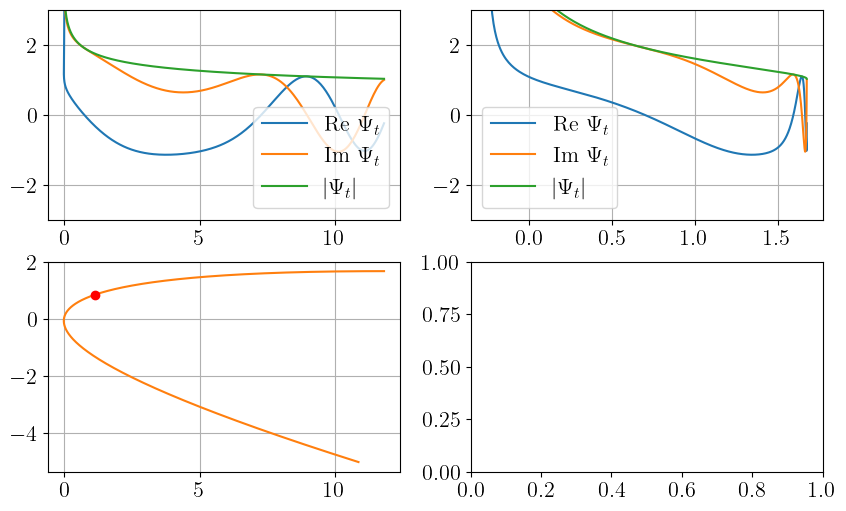

In [119]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0, 0].plot(Xs_t0[Field_t0 != 0], np.real((alpha_t[it]*Field_t0)[Field_t0 != 0]), label=r'Re $\Psi_t$')
ax[0, 0].plot(Xs_t0[Field_t0 != 0], np.imag((alpha_t[it]*Field_t0)[Field_t0 != 0]), label=r'Im $\Psi_t$')
ax[0, 0].plot(Xs_t0[Field_t0 != 0], np.abs((alpha_t[it]*Field_t0)[Field_t0 != 0]), label=r'$|\Psi_t|$')
ax[0, 0].set_ylim(-3, 3)
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].plot(Ks_t0[Field_t0 != 0], np.real((alpha_t[it]*Field_t0)[Field_t0 != 0]), label=r'Re $\Psi_t$')
ax[0, 1].plot(Ks_t0[Field_t0 != 0], np.imag((alpha_t[it]*Field_t0)[Field_t0 != 0]), label=r'Im $\Psi_t$')
ax[0, 1].plot(Ks_t0[Field_t0 != 0], np.abs((alpha_t[it]*Field_t0)[Field_t0 != 0]), label=r'$|\Psi_t|$')
ax[0, 1].set_ylim(-3, 3)
ax[0, 1].legend()
ax[0, 1].grid()

ax[1, 0].plot(Xs_t0, Ks_t0, color='tab:orange')
ax[1, 0].plot(Xs_t0[it], Ks_t0[it], 'ro')
ax[1, 0].grid()

#### Comparison of exact $\eta, \alpha$ vs. approximate values

In [120]:
eta_t_ex = (2*ks_ex/(v_ex**2)
              + 1j*(
                  (20*(ks_ex**6) + 11*(ks_ex**4) + 2*(ks_ex**2))
                  / ( v_ex**4 )))
alpha_t_ex = np.exp(- np.log(np.sqrt(v_ex))
              - 1j * (2*ks_ex**3 / 3)
              + 1j * (ks_ex**5 / (v_ex**2)))

# alpha_t_ex = (1/np.sqrt(v_ex)) * np.exp( - 1j * (2*ks_ex**3 / 3) + 1j * (ks_ex**5 / (v_ex**2)))

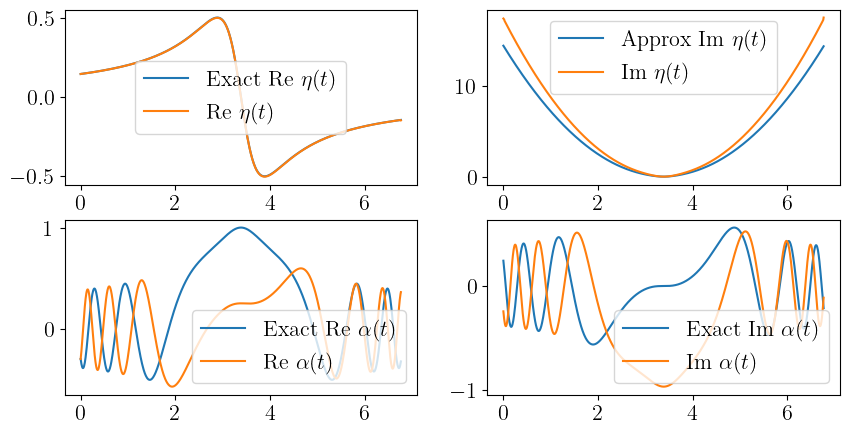

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes[0, 0].plot(t, np.real(eta_t_ex), label=r'Exact Re $\eta(t)$')
axes[0, 0].plot(t, np.real(eta_t), label=r'Re $\eta(t)$')
axes[0, 0].legend()

axes[0, 1].plot(t, np.imag(eta_t_ex), label=r'Approx Im $\eta(t)$')
axes[0, 1].plot(t, np.imag(eta_t), label=r'Im $\eta(t)$')
axes[0, 1].legend()

axes[1, 0].plot(t, np.real(alpha_t_ex), label=r'Exact Re $\alpha(t)$')
axes[1, 0].plot(t, np.real(alpha_t * np.conj(alpha_t_ex[0] / alpha_t[0])), label=r'Re $\alpha(t)$')
axes[1, 0].legend()

axes[1, 1].plot(t, np.imag(alpha_t_ex), label=r'Exact Im $\alpha(t)$')
axes[1, 1].plot(t, np.imag(alpha_t * np.conj(alpha_t_ex[0] / alpha_t[0])), label=r'Im $\alpha(t)$')
axes[1, 1].legend()
plt.show()

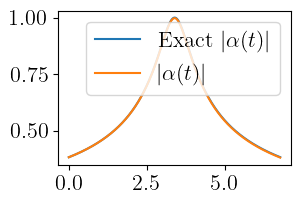

In [122]:
plt.figure(figsize=(3, 2))
plt.plot(t, np.abs(alpha_t_ex), label=r'Exact $|\alpha(t)|$')
plt.plot(t, np.abs(alpha_t * np.conj(alpha_t_ex[0] / alpha_t[0])), label=r'$|\alpha(t)|$')
plt.legend()
plt.show()

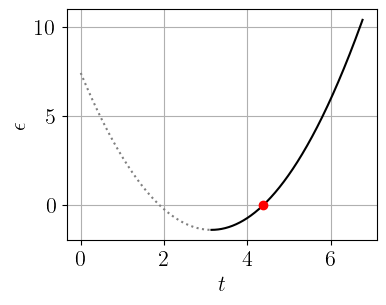

In [123]:
plt.figure(figsize=(4,3))
plt.plot(t[mask_t0], eps_t0[mask_t0], 'k-')
plt.plot(t[it], eps_t0[it], 'ro')
plt.plot(t[mask_t0 != True], eps_t0[mask_t0 != True], ':', color='grey')
plt.xlabel(r'$t$')
plt.ylabel(r'$\epsilon$')
plt.grid()

In [124]:
beta_t_ex_t0 = ks[it]**5/(v_ex[it]**2)
gamma_ex_t0 = ((ks[it]**2)/v_ex[it]) * eps_t0 - ks[it] * (eps_t0**2)
Theta_ex_t0 = (
    (8*(ks[it]**4) - (v_ex[it]**4))
    / (8*(ks[it]**2) * v_ex[it]) * eps_t0
    + (1/(4*ks[it])) * (eps_t0 **2)
    + ((v_ex[it]**6) - (v_ex[it]**4 - 8 * ks[it] * v_ex[it] * eps_t0)**(3/2))
    / (96*(ks[it]**3))
    )

# f_ex_t0 = ks[it]*(eps_t0**2) - (eps_t0**3)/(3*(v_ex[it]**3))
f_ex_t0 = Theta_ex_t0 - gamma_ex_t0
f_ex_t0_2 = ((v_ex[it]**6 - (v_ex[it]**4 - 8*v_ex[it]*ks[it]*eps_t0)**(3/2)) / ( 96 * ks[it]**3 )
           - v_ex[it]**3/(8*(ks[it]**2)) * eps_t0 + (v_ex[it]**2)/(4*ks[it]) * eps_t0**2
          )

Phi_ex_t0 = v_ex[it]/((v_ex[it]**4 - 8 * v_ex[it] * ks[it] * eps_t0)**(1/4))

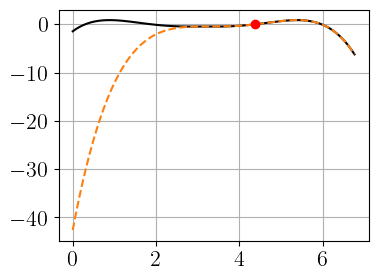

In [125]:
plt.figure(figsize=(4,3))
plt.plot(t, Theta_ex_t0, '-k')
plt.plot(t, Theta_t0, '--', color='tab:orange')
plt.plot(t[it], Theta_t0[it], 'ro')
plt.grid()

In [126]:
print('err on beta: ', np.round(np.abs(beta_t_ex_t0 - beta_t[it]), 4))

err on beta:  0.0


In [127]:
# plt.figure(figsize=(4, 2.5))
# plt.plot(t, beta_t_ex, 'k-', label=r'exact $\beta_t$')
# plt.plot(t, beta_t, '--', color='tab:orange', label=r'approx. $\beta_t$')
# plt.legend()
# plt.grid()
# plt.show()

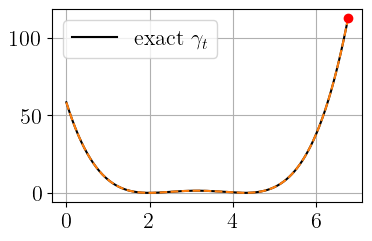

In [128]:
plt.figure(figsize=(4,2.5))
plt.plot(t, gamma_ex_t0, 'k-', label=r'exact $\gamma_t$')
plt.plot(t, gamma_t0, '--', color='tab:orange')
plt.plot(t[i1], gamma_ex_t0[i1], 'ro')
plt.legend()
plt.grid()
plt.show()

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


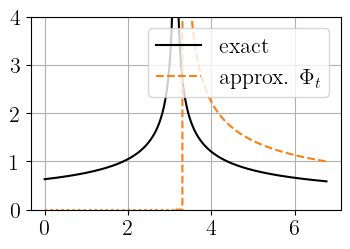

In [129]:
plt.figure(figsize=(4,2.5))
plt.plot(t, Phi_ex_t0, 'k-', label=r'exact')
plt.plot(t[mask_t0], Phi_t0[mask_t0], '--', color='tab:orange', label=r'approx. $\Phi_t$')
plt.plot(t[mask_t0 != True], Phi_t0[mask_t0 != True], ':', color='tab:orange')
plt.ylim(0, 4)
plt.legend()
plt.grid()
plt.show()

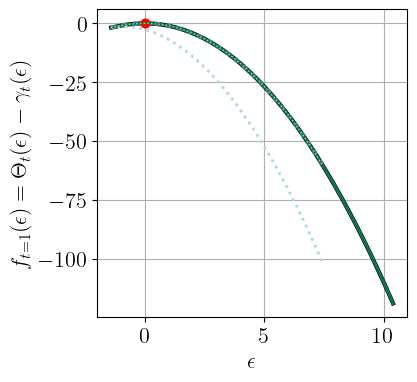

In [130]:
plt.figure(figsize=(4, 4))
plt.plot(eps_t0[mask_t0], f_ex_t0[mask_t0], '-k', linewidth=3)
plt.plot(eps_t0[mask_t0 != True], f_ex_t0[mask_t0 != True], ':', color='grey', linewidth=3)
plt.plot(eps_t0[it], f_ex_t0[it], 'ro', linewidth=3)

plt.plot(eps_t0[mask_t0], f_t0[mask_t0], '-', color='tab:blue', linewidth=2)
plt.plot(eps_t0[mask_t0 != True], f_t0[mask_t0 != True], ':', color='lightblue', linewidth=2)
plt.plot(eps_t0[it], f_t0[it], 'ro')

plt.plot(eps_t0[mask_t0], f_ex_t0_2[mask_t0], '-g', linewidth=1)
plt.plot(eps_t0[mask_t0 != True], f_ex_t0_2[mask_t0 != True], ':', color='lightgreen', linewidth=1)

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$f_{t=' + str(round(t_insp_in_s[i_insp], 2)) + '}(\epsilon) = \Theta_t(\epsilon) - \gamma_t(\epsilon)$')
plt.grid()

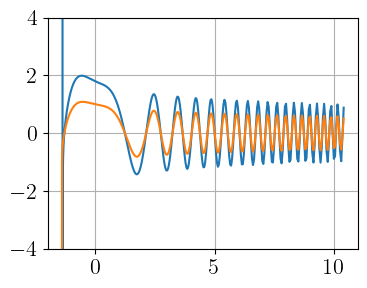

In [133]:
plt.figure(figsize=(4,3))
plt.plot(eps_t0[mask_t0], Phi_t0[mask_t0] * np.exp(1j*f_t0[mask_t0]))
plt.plot(eps_t0[mask_t0], g_fit(eps_t0[mask_t0]) * np.exp(1j*f_fit(eps_t0[mask_t0])))
plt.ylim(-4,4)
plt.grid()